In [131]:
import logging
import pandas as pd
import numpy as np
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

In [132]:
df = pd.read_csv('2020-12-31-DynamicallyGeneratedHateDataset-entries-v0.1.csv')
print(df.shape)

(40623, 11)


In [133]:
df.isnull().sum()

Unnamed: 0            0
id                    0
text                  0
label                 0
type                  0
model_wrong       14526
db.model_preds    14526
status                0
round                 0
split                 0
annotator             0
dtype: int64

In [134]:
df.duplicated().sum()

0

In [135]:
df = df.dropna()
df.shape

(26097, 11)

In [136]:
df['label'].value_counts()

hate       15253
nothate    10844
Name: label, dtype: int64

In [137]:
df.head(2)

,Unnamed: 0,id,text,label,type,model_wrong,db.model_preds,status,round,split,annotator
0,1,10000,It should be legal for a husband to rape his wife,hate,notgiven,True,0.97457,dynabench entry,1,train,gnzuctwed3
1,2,10001,dalits are lowlife scum,hate,notgiven,False,0.08233,dynabench entry,1,test,cagnluiznm


In [138]:
cond1a = df['label'] == 'hate'
cond1b = df['model_wrong'] == False

cond2a = df['label'] == 'nothate'
cond2b = df['model_wrong'] == True

In [139]:
df['AL_found'] = np.where((cond1a & cond1b)|
                          (cond2a & cond2b),
                           True,
                           False)

In [140]:
df.head(2)

,Unnamed: 0,id,text,label,type,model_wrong,db.model_preds,status,round,split,annotator,AL_found
0,1,10000,It should be legal for a husband to rape his wife,hate,notgiven,True,0.97457,dynabench entry,1,train,gnzuctwed3,False
1,2,10001,dalits are lowlife scum,hate,notgiven,False,0.08233,dynabench entry,1,test,cagnluiznm,True


In [141]:
df['AL_found'].value_counts()

False    15032
True     11065
Name: AL_found, dtype: int64

In [142]:
# sanity check
len(df[cond2a & cond2b]) + len(df[cond1a & cond1b])

11065

In [143]:
df.columns
df = df.drop(columns=['Unnamed: 0', 'id', 'type', 'model_wrong',
       'db.model_preds', 'status', 'round', 'split', 'annotator','label'])

In [144]:
df.head()

,text,AL_found
0,It should be legal for a husband to rape his wife,False
1,dalits are lowlife scum,True
2,dalits are lowlives,False
3,It was a better world when women dare not ques...,False
4,I don't work this hard so that those immigrant...,False


In [145]:
df['text'].apply(lambda x: len(x.split(' '))).sum()

416263

<AxesSubplot:>

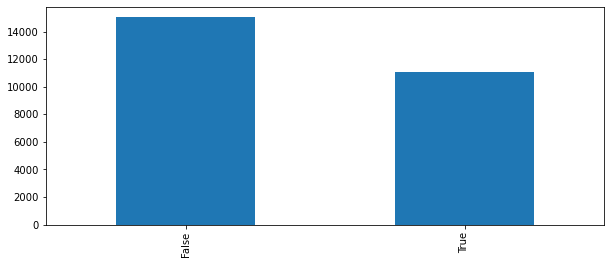

In [146]:
my_tags=[True, False]
plt.figure(figsize=(10,4))
df.AL_found.value_counts().plot(kind='bar')

In [147]:
# print sample of first 10 texts labeled "correctly" as hate:

for t in df[cond1a & cond1b]['text'][:5]:
    print(t)
    print('\n')
    
for t in df[cond2a & cond2b]['text'][:5]:
    print(t)
    print('\n')

dalits are lowlife scum


I don't work this hard so that all those pakis can take the benefits


I don't work this hard so that all those muslims can take the benefits


Why is it that Africans smell weird? Do they not wash?


Arabs are dumb


I dont hatefucking Islam


I dont hate fucking Muslims


Government is incompetent


short women are fucking cute


disabled people are stupid




In [148]:
def clean_text(text):
    
    text = text.lower()
    
    return text

In [149]:
df['text'] = df['text'].apply(clean_text)

In [150]:
for t in df[cond1a & cond1b]['text'][:5]:
    print(t)
    print('\n')
    
for t in df[cond2a & cond2b]['text'][:5]:
    print(t)
    print('\n')

dalits are lowlife scum


i don't work this hard so that all those pakis can take the benefits


i don't work this hard so that all those muslims can take the benefits


why is it that africans smell weird? do they not wash?


arabs are dumb


i dont hatefucking islam


i dont hate fucking muslims


government is incompetent


short women are fucking cute


disabled people are stupid




In [151]:
df['text'].apply(lambda x: len(x.split(' '))).sum()

416263

In [152]:
X = df.text
y = df.AL_found
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Naive Bayes Classifier for Multinomial Models

In [157]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [158]:
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.6934865900383141
              precision    recall  f1-score   support

       False       0.68      0.88      0.77      3016
        True       0.72      0.44      0.55      2204

    accuracy                           0.69      5220
   macro avg       0.70      0.66      0.66      5220
weighted avg       0.70      0.69      0.68      5220



# Linear Support Vector Machine


In [159]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [160]:
%%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.6522988505747126
              precision    recall  f1-score   support

       False       0.63      0.95      0.76      3016
        True       0.78      0.24      0.37      2204

    accuracy                           0.65      5220
   macro avg       0.71      0.60      0.57      5220
weighted avg       0.70      0.65      0.60      5220

CPU times: user 84.9 ms, sys: 1.85 ms, total: 86.7 ms
Wall time: 85.2 ms


# Logistic Regression

In [161]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

/Users/atsukosakurai/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=100000.0, n_jobs=1))])

In [162]:
%%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.6984674329501915
              precision    recall  f1-score   support

       False       0.74      0.74      0.74      3016
        True       0.64      0.64      0.64      2204

    accuracy                           0.70      5220
   macro avg       0.69      0.69      0.69      5220
weighted avg       0.70      0.70      0.70      5220

CPU times: user 86.7 ms, sys: 2.07 ms, total: 88.8 ms
Wall time: 87.4 ms


In [163]:
%%time
from gensim.models import Word2Vec

wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

CPU times: user 31.7 s, sys: 2.4 s, total: 34.1 s
Wall time: 34.2 s


In [164]:
from itertools import islice
list(islice(wv.vocab, 13030, 13050))

['Memorial_Hospital',
 'Seniors',
 'memorandum',
 'elephant',
 'Trump',
 'Census',
 'pilgrims',
 'De',
 'Dogs',
 '###-####_ext',
 'chaotic',
 'forgive',
 'scholar',
 'Lottery',
 'decreasing',
 'Supervisor',
 'fundamentally',
 'Fitness',
 'abundance',
 'Hold']

In [165]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [166]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [167]:
train, test = train_test_split(df, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values

In [168]:
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

<ipython-input-165-664dfaa6d69c>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


In [169]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['AL_found'])
y_pred = logreg.predict(X_test_word_average)

/Users/atsukosakurai/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [170]:
print('accuracy %s' % accuracy_score(y_pred, test['AL_found']))
print(classification_report(test['AL_found'], y_pred))

accuracy 0.6582375478927203
              precision    recall  f1-score   support

       False       0.68      0.78      0.73      4545
        True       0.62      0.49      0.54      3285

    accuracy                           0.66      7830
   macro avg       0.65      0.63      0.64      7830
weighted avg       0.65      0.66      0.65      7830



# Doc2vec and Logistic Regression

In [171]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

/Users/atsukosakurai/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [172]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

In [173]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['AL_found'], random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [174]:
all_data[:2]

[TaggedDocument(words=['transvestites', 'are', 'wrong'], tags=['Train_0']),
 TaggedDocument(words=['these', 'low', 'iq', 'black', 'colonies,', 'their', 'racist', 'ideologues', 'and', 'their', 'masters', 'have', 'been', 'pushing', 'systematic', 'racism', 'against', '85%', 'native', 'white', 'population.'], tags=['Train_1'])]

In [175]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 26097/26097 [00:00<00:00, 2797095.84it/s]


In [176]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 26097/26097 [00:00<00:00, 3721694.31it/s]


In [177]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [178]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [179]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)

/Users/atsukosakurai/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=100000.0, n_jobs=1)

In [180]:
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)

/Users/atsukosakurai/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [182]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.6369093231162196
              precision    recall  f1-score   support

       False       0.65      0.78      0.71      4504
        True       0.60      0.44      0.51      3326

    accuracy                           0.64      7830
   macro avg       0.63      0.61      0.61      7830
weighted avg       0.63      0.64      0.63      7830



# BOW with keras

In [183]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras import utils

In [184]:
train_size = int(len(df) * .7)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(df) - train_size))

Train size: 18267
Test size: 7830


In [185]:
train_posts = df['text'][:train_size]
train_tags = df['AL_found'][:train_size]

test_posts = df['text'][train_size:]
test_tags = df['AL_found'][train_size:]

In [ ]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [ ]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [ ]:
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [ ]:
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [ ]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

In [ ]:
batch_size = 32
epochs = 2

In [ ]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

In [ ]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])